# Big Tech Stock Predictor

The goal of this project is to use AAPL stock as a tool to leverage different machine learning and deep learning regressors to predict the stock price / movement across an array of intervals to see how accurate ML / DL models can be.

**What is being predicted?**

The predicted feature for this research is the adjusted close as this is the standard for comparing price of a security irregardless of security splits / other external factors, and thus this will be the target feature that the regressors will be trying to estimate.

# Data Pre-Processing

In this step, we are preparing the data to be used in training the models.

Note that feature engineering has already been performed manually on this dataset to add in extra columns, and thus the resulting CSV file is already engineered. I added in manually the column for Earnings (0 representing non-earnings the next day and 1 representing an earnings report the following day), and also predicted EPS (earnings per share) and actual EPS columns.

Citation for AAPL stock inital data: https://www.kaggle.com/datasets/evangower/big-tech-stock-prices/?select=AAPL.csv

Citation for Earnings, Predicted and Actual EPS data: https://www.alphaquery.com/stock/AAPL/earnings-history

Note also that our target variable - actual adj close - varies depending on the time frame we are trying to predict as it shifts depending on how far out we are attempting to forecast.

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Extract the timestamp from the datetime and convert it to float
df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Visualization of features

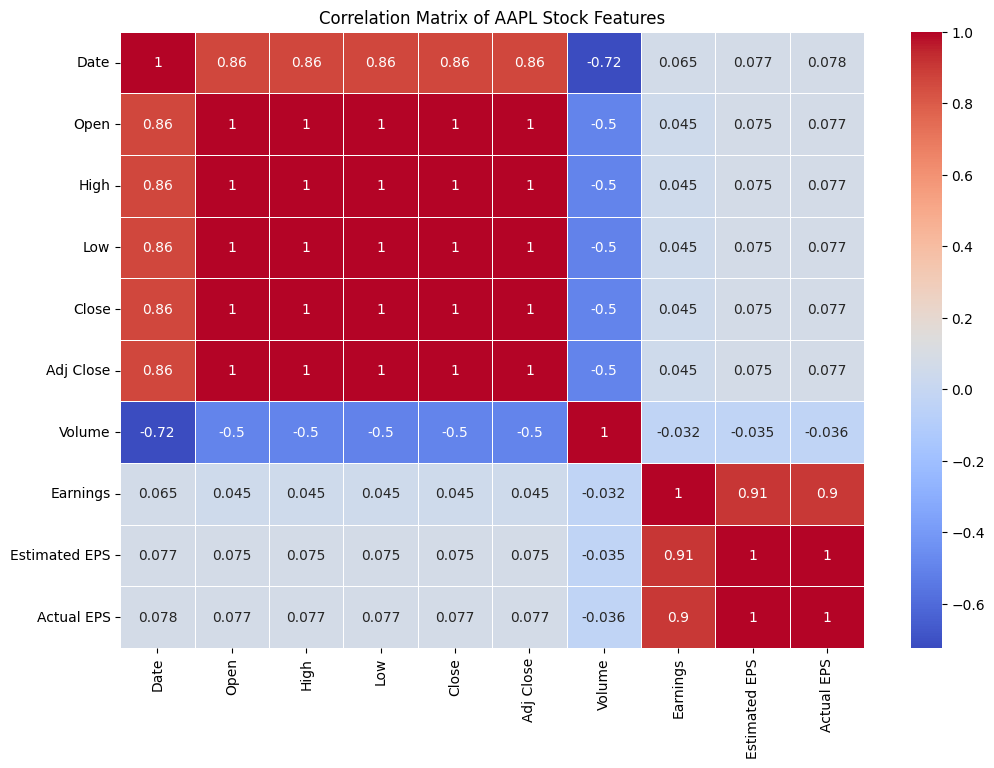

In [56]:
correlation_matrix = df_aapl.corr()

plt.figure(figsize=(12, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Matrix of AAPL Stock Features')
plt.show()

# I would like to do a feature seaborn correlation graph to see how correlated features are. Maybe PCA analysis too?

# Linear Regression Model

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

Overall size of predictions for a day (non-earnings) out: 648
Overall modified Accuracy
0.9734665831249256
Mean Squared Error (adj price in dollars amount off): 1.9762541301283552
Custom Prediction for next day, actual adj close is 51.719452
Linear Regression model predicted for next day: [53.75805364]
Accuracy of Custom Prediction:
[96.05834639]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


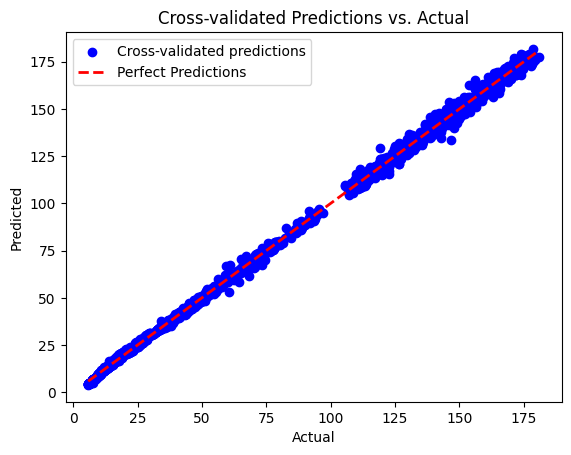

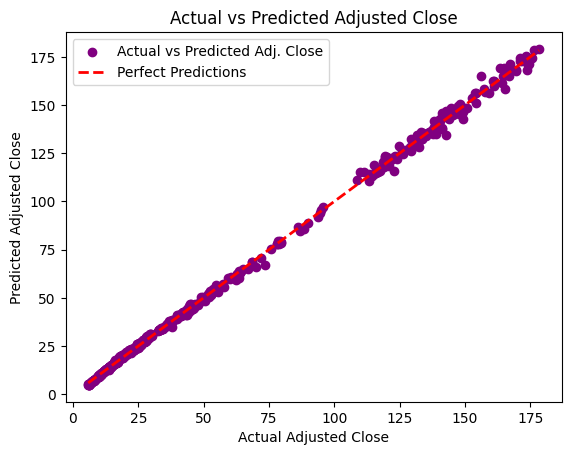

In [57]:
# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (non-earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next day, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next day: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Analysis of non-earnings eve results**

In the above graphs, we can see a very interested spread of our model's predictions. In the Actual vs Predicted Adjusted Close graph, we can see that the linear regression model is quite accurate at the start of the actual adjusted close price, but as the adjusted close price goes on (and thus time also increases due to correlation), we see that the model is less accurate with its predictions straying further from the perfect prediction trend line. This phenomena also extends to the accuracy of the cross-validated predictions as well, and can be best explained through the increase of market volatility over recent years.

Market volatility will likely become even more prevalent as time goes on, and thus is something that must be accounted for in making predictions. However, it is interesting that its visualization is so readily obvious in the above graphs.

**Next Day Prediction (earnings eve)**

<ipython-input-58-f92826a8e5b0>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-58-f92826a8e5b0>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-58-f92826a8e5b0>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-58-f92826a8e5b0>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-58-f92826a8e5b0>:19: FutureWarning: The frame.append method is deprecated and will be removed f

Overall size of predictions for a day (earnings) out: 13
Overall modified Accuracy
0.9469509016415854
Mean Squared Error (adj price in dollars amount off): 14.540673159714526
Custom Prediction for next earnings day, actual adj close is 49.889595
Linear Regression model predicted for next earnings day: [55.19031045]
Accuracy of Custom Prediction:
[89.37510828]


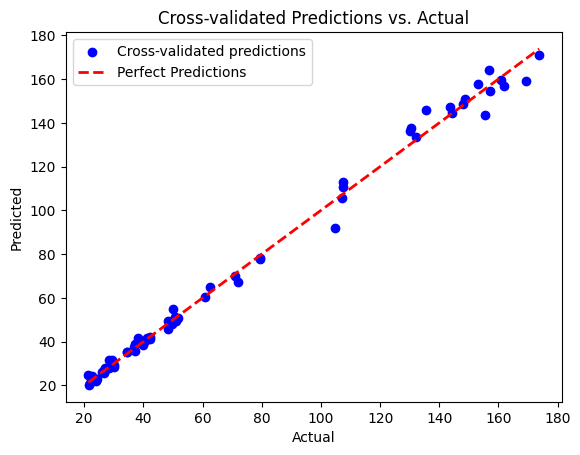

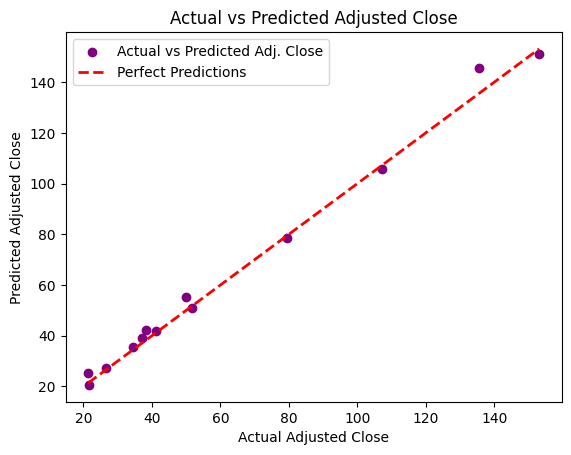

In [58]:
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        selected_rows = selected_rows.append(row)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          selected_rows = selected_rows.append(df_aapl.loc[index + 1])

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame or list of tuples with predicted and actual values
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_aapl, predicted)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next earnings day, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next earnings day: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

**Analysis of earnings eve results**

Similar to the above non-earnings eve results, we can see that our linear regression model performs much more accurately when the actual adjusted close price is lower, and becomes more erratic as the share price increases, ie time goes on. Besides having much fewer data points to work with, earnings is particularly interesting as it is readily known that even if a company beats earnings estimates, the stock price can still decrease based on the whims of the market and other external factors, thus, achieving accuracy with the linear regression model for this application is difficult but intriguing. As in recent years past, with increased market volatility we can see this trend demonstrated yet again across both the cross-validated prediction and predicted adjusted close vs actual.

**Next Month Stock Prediction (non-earnings)**

Note that the shift for the monthly data is not quite as linear as simply shifting over by 1 for the subsequent day due to varying month length. Instead, an average has been taken between different months to use an approximation of the number of market open days that elaspses in a monthly interval. An approximation of 22 market open days between monthly intervals was found to best estimate this shift.


Overall size of predictions for a month out: 644
Overall modified Accuracy
0.9239050532886381
Mean Squared Error (adj price in dollars amount off): 39.13340555174681
Custom Prediction for next month, actual adj close is 131.159927
Linear Regression model predicted for next month: [148.36818551]
Accuracy of Custom Prediction:
[86.87994199]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


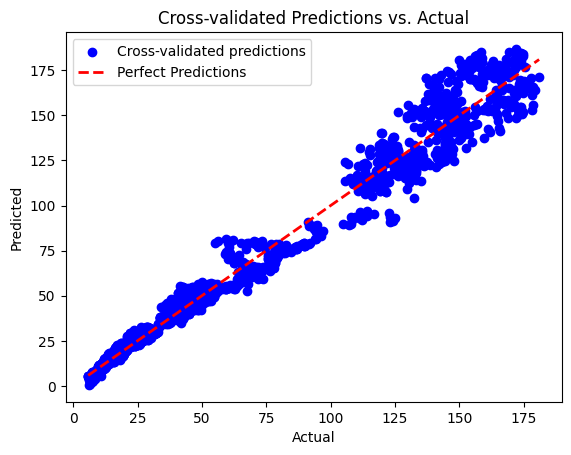

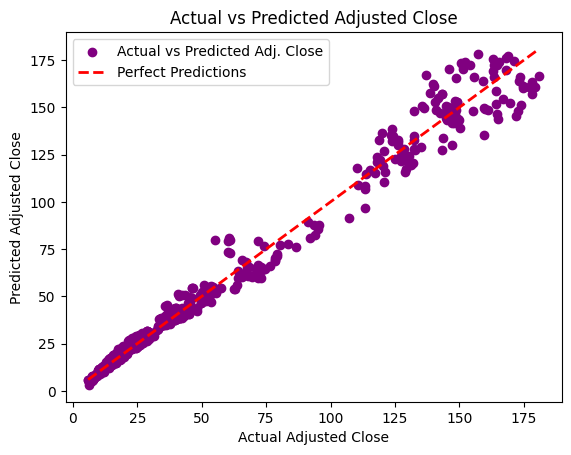

In [59]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later to simulate a month
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-22)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a month out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2022-05-17)
custom_values = np.array([[148.860001,149.770004,146.679993,149.240005,78336300,0]])

# This would be the date (2022-06-17)
actual_adj_value = 131.159927

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example (2022-05-17) predicting (2022-06-17)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next month, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next month: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Year Stock Prediction (non-earnings)**

To determine the 250 value as the proper amount to shift, I used the .tail() method to see the last values of the df, and adjusted the amount so that the tail end of the data cut off as close to 1 year earlier as possible, ensuring the closest possible business day shift for the dataset. Also manual testing was performed in Excel to ensure 250 provided a realistic shift to simulate a year.

Overall size of predictions for a year out: 599
Overall modified Accuracy
0.756636302671759
Mean Squared Error (adj price in dollars amount off): 239.59020208876785
Custom Prediction for next year, actual adj close is 51.923771
Linear Regression model predicted for next year: [210.35741958]
Accuracy of Custom Prediction:
[-205.12739257]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


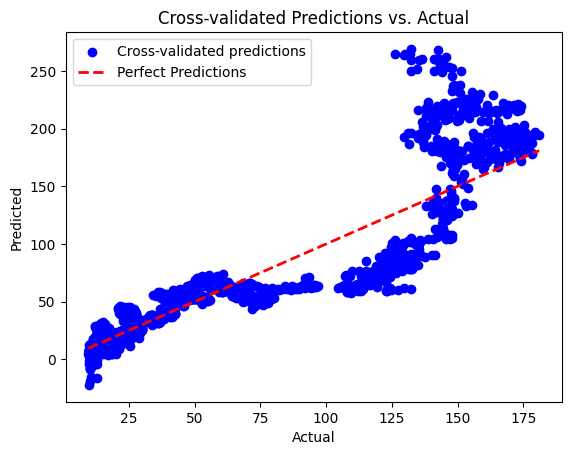

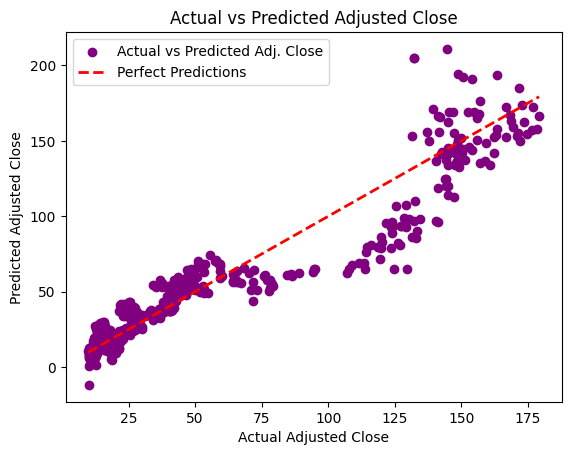

In [60]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately one year (250 business market open) days later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-250)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
# custom_values = np.array([[54.200001,54.297501,53.507500,53.759998,104639200,0]])

custom_values = np.array([[181.27,183.89,180.97,183.79,54274900,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next year: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Decade Stock Prediction (non-earnings)**

The 2520 value as the approximation for business days in a decade was found to be most suitable for this dataset using a similar method as the yearly shift estimate in the above cell.

Overall size of predictions for a decade out: 151
Overall modified Accuracy
0.8470992988039348
Mean Squared Error (adj price in dollars amount off): 452.4309932868789
Custom Prediction for next decade, actual adj close is 168.119446
Linear Regression model predicted for next decade: [199.91792298]
Accuracy of Custom Prediction:
[81.08578291]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


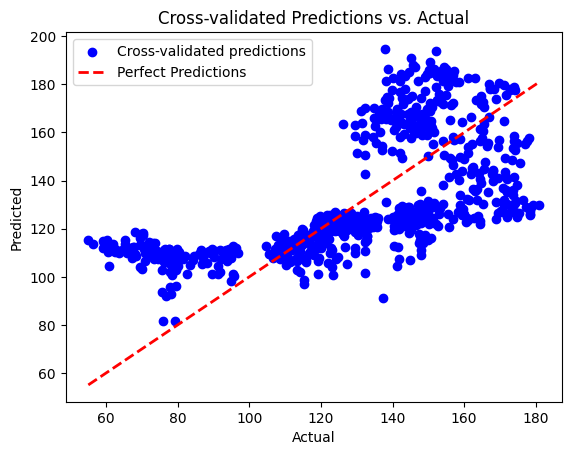

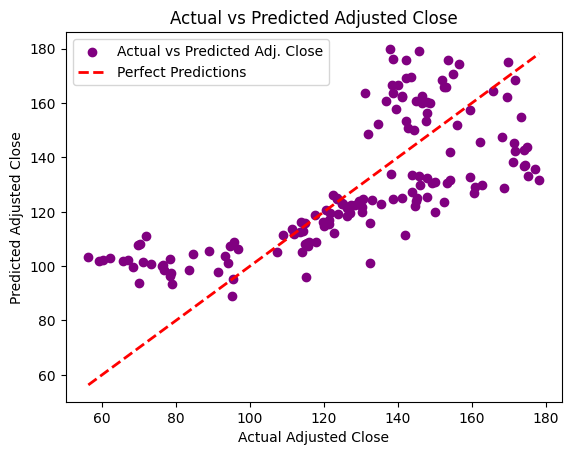

In [61]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
# df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# # Extract the timestamp from the datetime and convert it to float
# df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 2520 business (market open) days later to simulate a decade later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a decade out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2012-02-14)
# custom_values = np.array([[18.023571,18.198570,17.928572,18.195000,460398400,0]])

custom_values = np.array([[28.410000,28.480000,28.027500,28.129999,119526000,0]])


# This would be the date (2022-02-14)
actual_adj_value = 168.119446

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 2012-02-14 predicting 2022-02-14
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next decade, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Random Forest Regressor

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

MSE of RF Regressor (adj price in dollars amount off): 2.455991753444751
2.455991753444751
Overall size of predictions for a day (non-earnings) out: 648
Overall modified Accuracy
0.9824594038554918
Custom Prediction for next day, actual adj close is 51.719452
Random Forest model predicted for next day: [52.90652948]
Accuracy of Custom Prediction:
[97.7047756]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


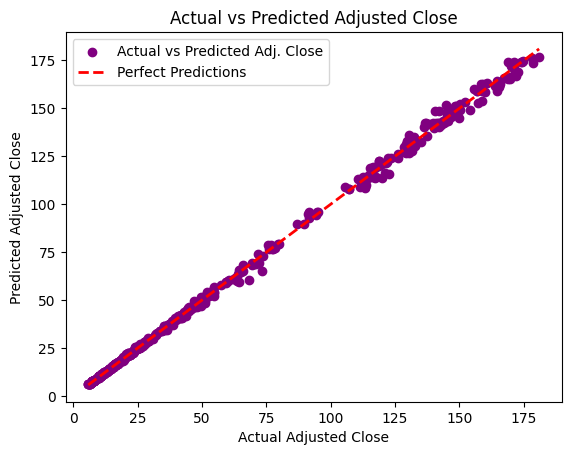

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (non-earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next day, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next day: {custom_predictions}")


print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Day Prediction (earnings eve)**
Uses earnings eve rows and subsequent earnings day rows as pairs to predict the earnings day adjusted price based upon earnings eve

<ipython-input-63-51ae7c83829a>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-63-51ae7c83829a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-63-51ae7c83829a>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-63-51ae7c83829a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-63-51ae7c83829a>:19: FutureWarning: The frame.append method is deprecated and will be removed f

MSE of RF Regressor (adj price in dollars amount off): 21.188389408586833
21.188389408586833
Overall size of predictions for a day out (earnings) out: 13
Overall modified Accuracy
0.9544006469447535
Accuracy of Custom Prediction:
[97.88677571]
Custom Prediction for next day (earnings), actual adj close is 49.889595
Random Forest model predicted for next day (earnings): [50.94387404]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


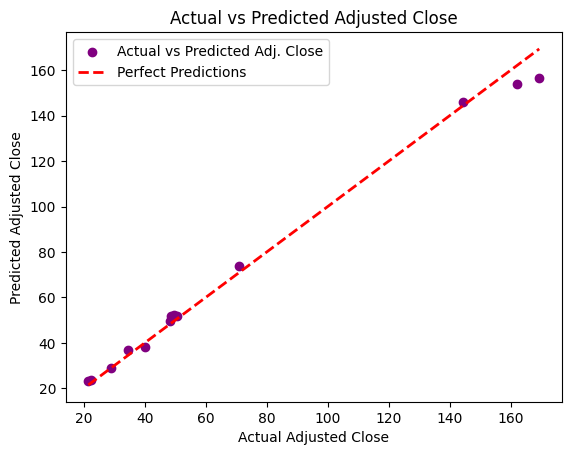

In [63]:
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        selected_rows = selected_rows.append(row)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          selected_rows = selected_rows.append(df_aapl.loc[index + 1])

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))


print(f"Overall size of predictions for a day out (earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

print(f"Custom Prediction for next day (earnings), actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next day (earnings): {custom_predictions}")

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

**Next Month Prediction**

MSE of RF Regressor (adj price in dollars amount off): 28.358499173626996
28.358499173626996
Overall size of predictions for a month out: 644
Overall modified Accuracy
0.9427518520985807
Custom Prediction for next month, actual adj close is 131.159927
Random Forest model predicted for next month: [154.0902597]
Accuracy of Custom Prediction:
[82.51727245]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


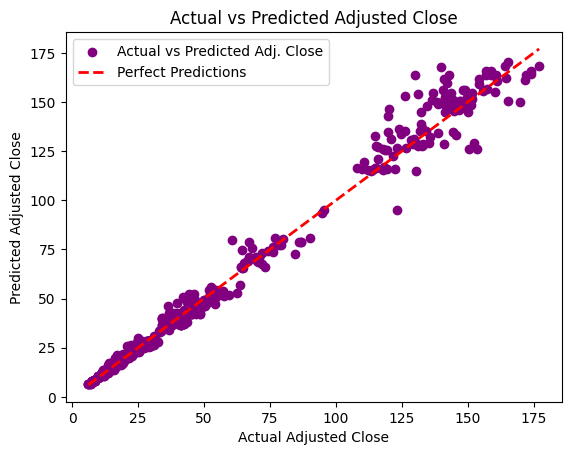

In [64]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later to simulate a month later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-22)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a month out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2022-05-17)
custom_values = np.array([[148.860001,149.770004,146.679993,149.240005,78336300,0]])

# This would be the date (2022-06-17)
actual_adj_value = 131.159927

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the random forest regression model
# for our custom values (test example 2022-05-17 predicting 2022-06-17)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next month, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next month: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Year Prediction**

MSE of RF Regressor (adj price in dollars amount off): 103.0299736025792
103.0299736025792
Overall size of predictions for a year out: 599
Overall modified Accuracy
0.8718146430451388
Custom Prediction for next year, actual adj close is 51.923771
Random Forest model predicted for next year: [65.18626694]
Accuracy of Custom Prediction:
[74.45775665]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


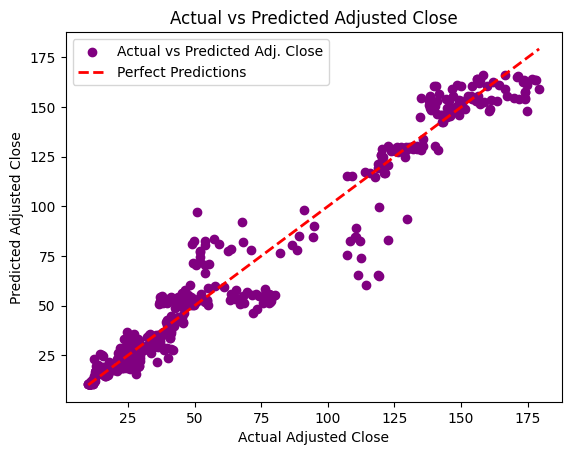

In [65]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 250 business (market open) days later to simulate a year later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-250)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
custom_values = np.array([[54.200001,54.297501,53.507500,53.759998,104639200,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next year: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Decade Prediction**

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

MSE of RF Regressor (adj price in dollars amount off): 110.12011292614673
110.12011292614673
Overall size of predictions for a decade out: 151
Overall modified Accuracy
0.9321468726232183
Custom Prediction for next decade, actual adj close is 168.119446
Random Forest model predicted for next decade: [157.36832601]
Accuracy of Custom Prediction:
[93.60507053]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


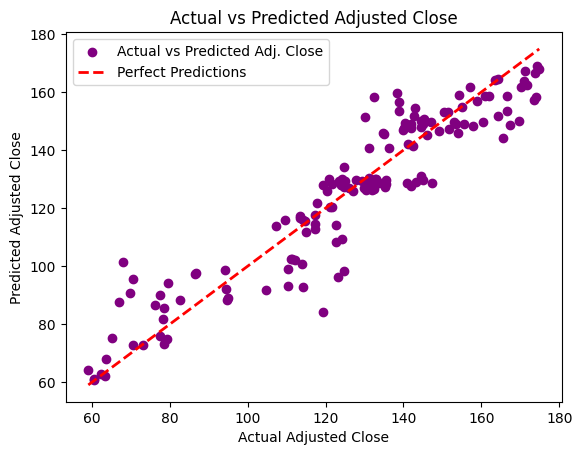

In [66]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 2520 business (market open) days later to simulate a decade later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a decade out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2012-02-14)
# custom_values = np.array([[18.023571,18.198570,17.928572,18.195000,460398400,0]])

custom_values = np.array([[134.350006,134.559998,130.300003,132.229996,77852100,0]])

# This would be the date (2022-02-14)
actual_adj_value = 168.119446

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2012-02-14 predicting 2022-02-14)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next decade, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Long-Short Term Memory

Epoch 1/12
18/18 [==============================] - 11s 162ms/step - loss: 0.9745 - val_loss: 0.9820
Epoch 2/12
18/18 [==============================] - 2s 87ms/step - loss: 0.8124 - val_loss: 0.6935
Epoch 3/12
18/18 [==============================] - 2s 84ms/step - loss: 0.5756 - val_loss: 0.5872
Epoch 4/12
18/18 [==============================] - 2s 86ms/step - loss: 0.3865 - val_loss: 0.4944
Epoch 5/12
18/18 [==============================] - 2s 130ms/step - loss: 0.3235 - val_loss: 0.3349
Epoch 6/12
18/18 [==============================] - 2s 122ms/step - loss: 0.2565 - val_loss: 0.1836
Epoch 7/12
18/18 [==============================] - 2s 88ms/step - loss: 0.2318 - val_loss: 0.1887
Epoch 8/12
18/18 [==============================] - 1s 83ms/step - loss: 0.2004 - val_loss: 0.1703
Epoch 9/12
18/18 [==============================] - 2s 84ms/step - loss: 0.1620 - val_loss: 0.1326
Epoch 10/12
18/18 [==============================] - 2s 83ms/step - loss: 0.1431 - val_loss: 0.1268
Epoch

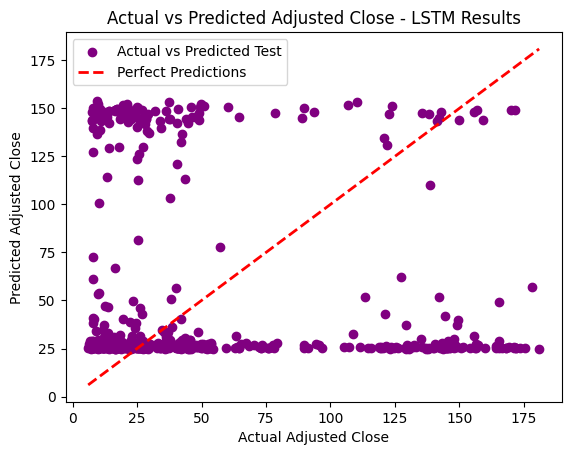

In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and actual EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considering earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input data to be 3D [samples, time steps, features]
time_steps = 30  # You can experiment with different time steps
X_train_reshaped = np.array([X_train_scaled[i:i+time_steps, :] for i in range(len(X_train_scaled)-time_steps+1)])
X_test_reshaped = np.array([X_test_scaled[i:i+time_steps, :] for i in range(len(X_test_scaled)-time_steps+1)])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train_reshaped.shape[2])))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train_scaled, epochs=12, batch_size=128, validation_split=0.1, verbose=1)

# Make predictions
train_predict = scaler_y.inverse_transform(model.predict(X_train_reshaped))
test_predict = scaler_y.inverse_transform(model.predict(X_test_reshaped))

# Calculate root mean squared error
train_rmse = np.sqrt(mean_squared_error(y_train.values[time_steps:], train_predict[:len(y_train) - time_steps]))
test_rmse = np.sqrt(mean_squared_error(y_test.values[time_steps:], test_predict[:len(y_test) - time_steps]))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

# Combine the training and testing predictions with the original data
all_predictions = np.concatenate([train_predict, test_predict])
all_actuals = np.concatenate([y_train.values[time_steps:], y_test.values[time_steps:]])

# Plot the actual difference between the predicted and actual adjusted close for testing data
plt.scatter(y_test.values[time_steps:], test_predict[:len(y_test) - time_steps], color='purple', label='Actual vs Predicted Test')

# Plot a diagonal line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close - LSTM Results')
plt.legend()
plt.show()

# Support Vector Regression (SVR)

Best Hyperparameters: {'C': 100, 'degree': 2, 'epsilon': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
MSE of RF Regressor (adj price in dollars amount off): 165.96900267868253
165.96900267868253
Overall size of predictions for a year out: 151
Overall modified Accuracy
0.9193481633758203
Custom Prediction for next year, actual adj close is 51.923771
SVR model predicted for next decade: [129.24292017]
Accuracy of Custom Prediction:
[-48.90896343]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


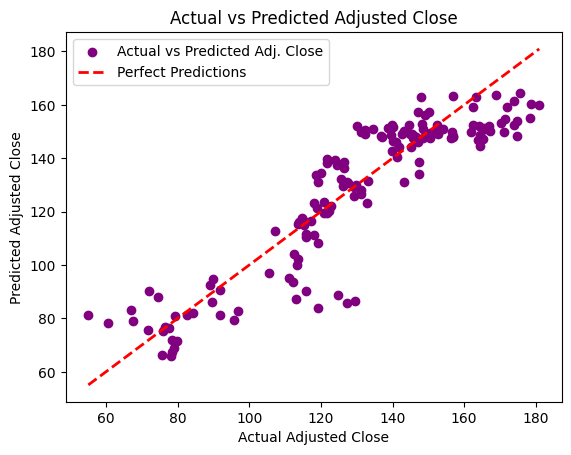

In [69]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the non-earnings rows (i.e., where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
y_aapl = df_aapl_non['Target Adj Close']
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# SVR model
svr = SVR()

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1],
              'kernel': ['linear', 'rbf', 'poly'],
              'epsilon': [0.1, 0.2, 0.5],
              'degree': [2, 3, 4]}

grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train SVR model with best hyperparameters
best_svr = SVR(**best_params)
best_svr.fit(X_train_scaled, y_train)

# Make predictions
predictions = best_svr.predict(X_test_scaled)

# Calculate root mean squared error
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
custom_values = np.array([[139.899994,141.350006,138.220001,138.979996,77033700,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = best_svr.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"SVR model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()
